In [3]:
# Please visit:
#
# https://download.nkg-mn.com/credo/anomalies/
#
# Pretrained dots_100000.h5 and others can be downloaded from mentioned website.

In [4]:
from align_images_pca import align_image
from PIL import Image
import numpy as np
import glob


DOTS_SRC = 'hit-images-final2/dot'
TRACKS_SRC = 'hit-images-final2/line'
WORMS_SRC = 'hit-images-final2/worms'


def load_images(src):
    images = []
    files = list(glob.glob("%s/*.png" % src))
    files = sorted(files)
    for image_path in files:
        img = Image.open(image_path)
        img = img.convert('L')
        image = np.asarray(img)
        #image = np.asarray(Image.open(image_path).convert('L'))
        image = align_image(image)
        mask = np.where(image > 25, 1, 0)
        image = mask * image
        image = image.astype(np.float32) / np.max(image)
        image = np.expand_dims(image, 2)
        images.append(image)
    return np.asarray(images), files


dots_set, dots_files = load_images(DOTS_SRC)
tracks_set, tacks_files = load_images(TRACKS_SRC)
worms_set, worms_files = load_images(WORMS_SRC)

tracks_set = np.vstack([tracks_set, dots_set])
tacks_files = np.hstack([tacks_files, dots_files])

In [5]:
def augmentation_mirror(src, files):
    images = []
    files_aug = []
    for i in range(0, len(src)):
        img = src[i]
        images.append(img)
        images.append(np.flip(img))
        files_aug.append(files[i])
        files_aug.append(files[i])
    return np.asarray(images), files_aug


tracks2_set, tacks2_files = augmentation_mirror(tracks_set, tacks_files)
worms2_set, worms2_files = augmentation_mirror(worms_set, worms_files)

In [6]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    p = np.random.permutation(df.shape[0])
    n = int(train_percent * len(p))
    m = int(validate_percent * len(p)) + n
    train = p[:n]
    validation = p[n:m]
    test = p[m:]
    return train, validation, test


tracks2_train, tracks2_validate, tracks2_test = train_validate_test_split(tracks2_set)
worms2_train, worms2_validate, worms2_test = train_validate_test_split(worms2_set)

320
0
128
18496
0
256
0
230416
244800
0
36928
0
256
18464
0
128
289
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 60, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 30, 30, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 15, 15, 64)        0 

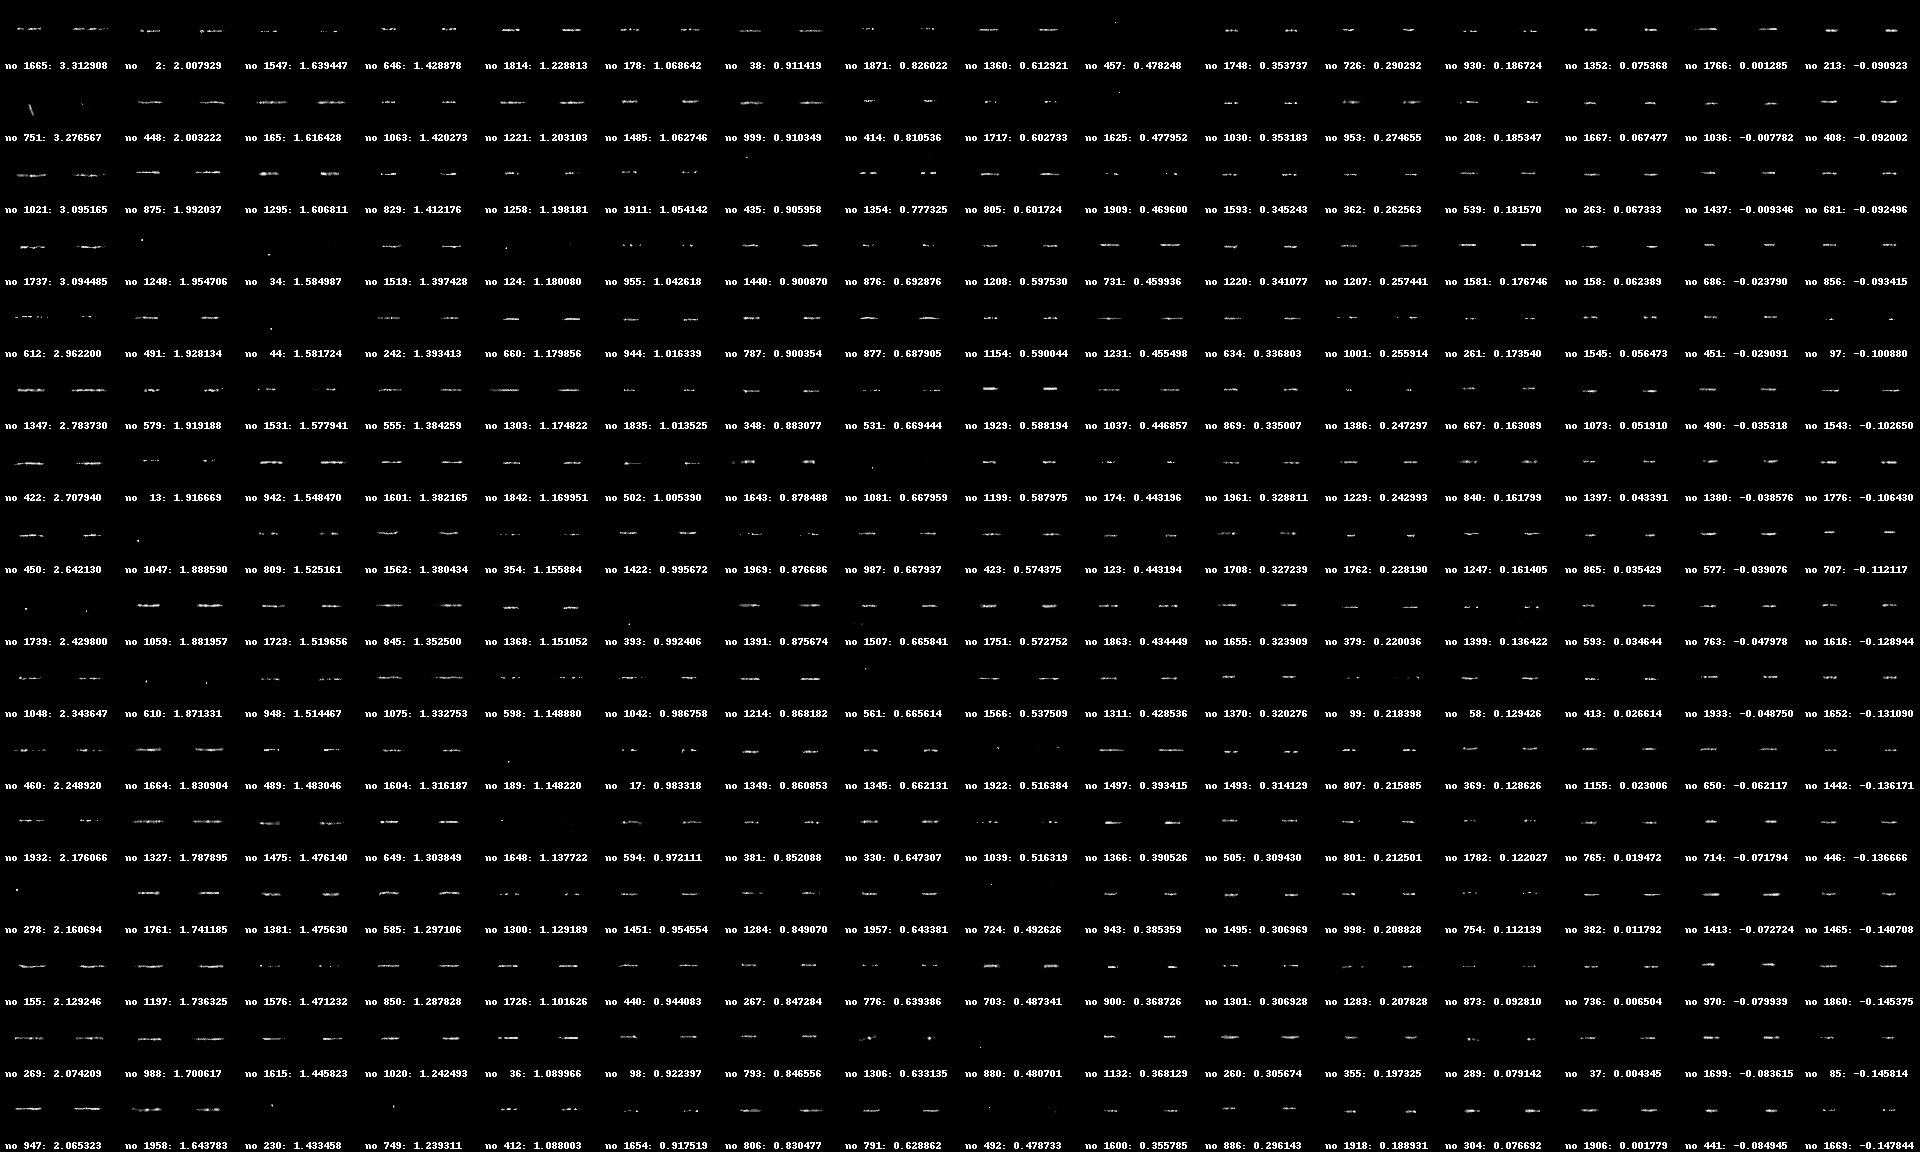

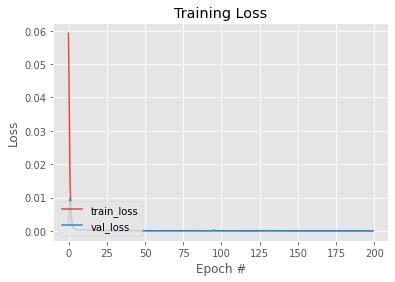

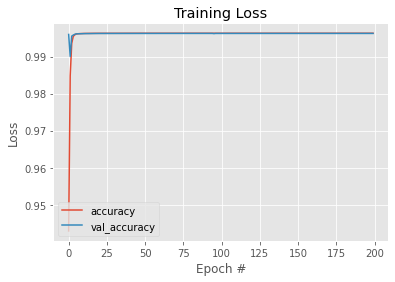

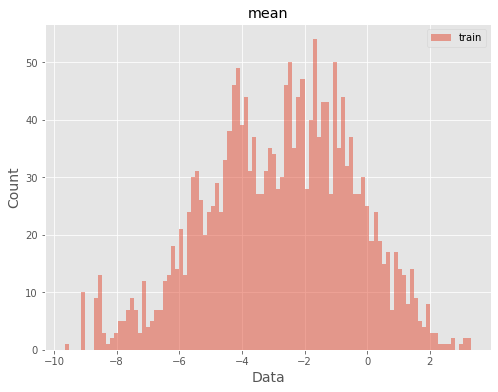

In [7]:
from commons import *
from dataset_loader import load_from_file
from IPython.display import display
import matplotlib.pyplot as plt
import cv2

#DOTS_DST = 'cache/dots_100000.pickle'
#ARTIFACTS_DST = 'cache/artifacts_100000.pickle'

#DOTS_AC = 'cache/dots_100000.h5'
TRACKS_AC = 'cache/th_dots_optics_100000.h5'
#WORMS_AC = 'cache/worms_100000.h5'
#ARTIFACTS_AC = 'cache/artifacts_100000.h5'

def train_and_test(train_set, validation_set, fn):
    autoencoder = original_autoencoder()
    autoencoder = train_or_cache(train_set, autoencoder, fn, validation_set=validation_set, force_train=True)

    for df_func, df_name in zip(
            [dm_func_mean],
            ['mean']
    ):
        for img_set, set_names in zip([validation_set], ['train']):
            decoded = autoencoder.predict(img_set)

            vis, errors = visualize_predictions(decoded, img_set, df_func, False, 16)
            img_path = fn.replace('.h5', '-vis.png')
            hist_path = fn.replace('.h5', '-hist.png')
            cv2.imwrite(img_path, vis)
            display(Image.open(img_path))
            if len(img_set) > 256:
                vis, errors = visualize_predictions(decoded, img_set, df_func, False)
                img_path = fn.replace('.h5', '-vis_full.png')
                cv2.imwrite(img_path, vis)

            plt.figure(figsize=(8,6))
            plt.hist(errors, bins=100, alpha=0.5, label=set_names)
            plt.xlabel("Data", size=14)
            plt.ylabel("Count", size=14)
            plt.title(df_name)
            plt.legend(loc='upper right')
            plt.savefig(hist_path)


train_and_test(tracks2_set[tracks2_train], tracks2_set[tracks2_validate], TRACKS_AC)

In [8]:
from keras.models import load_model

def encoder_embedding(model_file, test_set):
    encoder = load_model(model_file.replace('.h5', '-encoder.h5'))
    embedding = encoder.predict(test_set)
    #with_c = np.vstack([v, np.ones(v.shape) * c])
    #transposed = with_c.transpose()
    return embedding

In [24]:
def dbscan(embedding, t_files, eps):
    img_count = len(embedding)
    threshold = 1
    p = 16

    #for a in range(emb_array.shape[0]):
    #    emb_array[a] = emb_array[a] / w

    #emb_array_copy = np.copy(emb_array[0:img_count, 3:50])
    emb_array_copy = np.copy(embedding[0:img_count, 0:p])


    from sklearn.cluster import DBSCAN
    from sklearn import metrics
    from sklearn.datasets import make_blobs
    from sklearn.preprocessing import StandardScaler

    db = DBSCAN(min_samples=5, eps=eps).fit(emb_array_copy)
    #core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    #core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    import matplotlib.pyplot as plt

    # Black removed and is used for noise instead.
    """
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = labels == k

        xy = emb_array_copy[class_member_mask & core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
        )

        xy = emb_array_copy[class_member_mask & ~core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )
    """
    result = np.where(labels == -1)
    my_ids = result[0]
    print(labels)
    print(my_ids)
    print(len(my_ids))


    import matplotlib.pyplot as plt


    fig = plt.figure(figsize=(32, 32))
    columns = 5
    rows = int(len(my_ids) / 5) + 1

    for aaa in range(len(my_ids)):
        #img_help = cv2.imread('d:\\dane\\credo\\png\\' + all_files_names[my_ids[aaa]])
        img_help = cv2.imread(t_files[my_ids[aaa]])
        print(t_files[my_ids[aaa]])

        aaa1 = aaa + 1
        xxxxx = (aaa % 5) + 1
        r = fig.add_subplot(rows, columns, aaa1)
        r.axis("off")
        plt.imshow(img_help)
        #cv2.imshow(str(aaa), img_help)
        #print(all_files_names[my_ids[0]])

    plt.show()


In [25]:
tracks_embedding = encoder_embedding(TRACKS_AC, tracks2_set[tracks2_test])
tracks_t_files = np.asarray(tacks2_files)[tracks2_test]
dbscan(tracks_embedding, tracks_t_files, 120)

KeyboardInterrupt: 

[ 0  0  0 ...  0 -1 -1]
[  17   60   95  158  217  235  259  263  264  302  308  315  329  352
  379  431  435  509  540  572  718  756  760  768  855  873  881  942
 1026 1080 1124 1159 1182 1198 1229 1234 1358 1442 1484 1514 1564 1567
 1601 1684 1700 1725 1740 1827 1884 1885 1919 1928 1976 1978 1980 1982
 1984 1985 1988 1992 1993 1999 2000 2003 2004 2005 2008 2015 2016 2017
 2019 2020 2021 2022 2023 2024 2028 2029 2031 2033 2034 2036 2038 2040
 2041 2042 2043 2044 2045 2046 2047 2049 2053 2054 2056 2057 2059 2061
 2063 2064 2065 2069 2071 2072 2074 2075 2079 2080 2085 2086 2087 2088
 2089 2090 2091 2093 2094 2097 2098 2102 2103 2104 2105 2106 2107 2109
 2110 2113 2115 2117 2118 2119 2120 2122 2123 2127 2133 2134 2136 2138
 2140 2141 2147 2148 2154 2155 2156 2158 2159 2162 2163 2168 2170 2173
 2174]
155
hit-images-final2/line\22009779.png
hit-images-final2/line\21978364.png
hit-images-final2/line\23300748.png
hit-images-final2/line\24579235.png
hit-images-final2/line\23768588.png
hit-

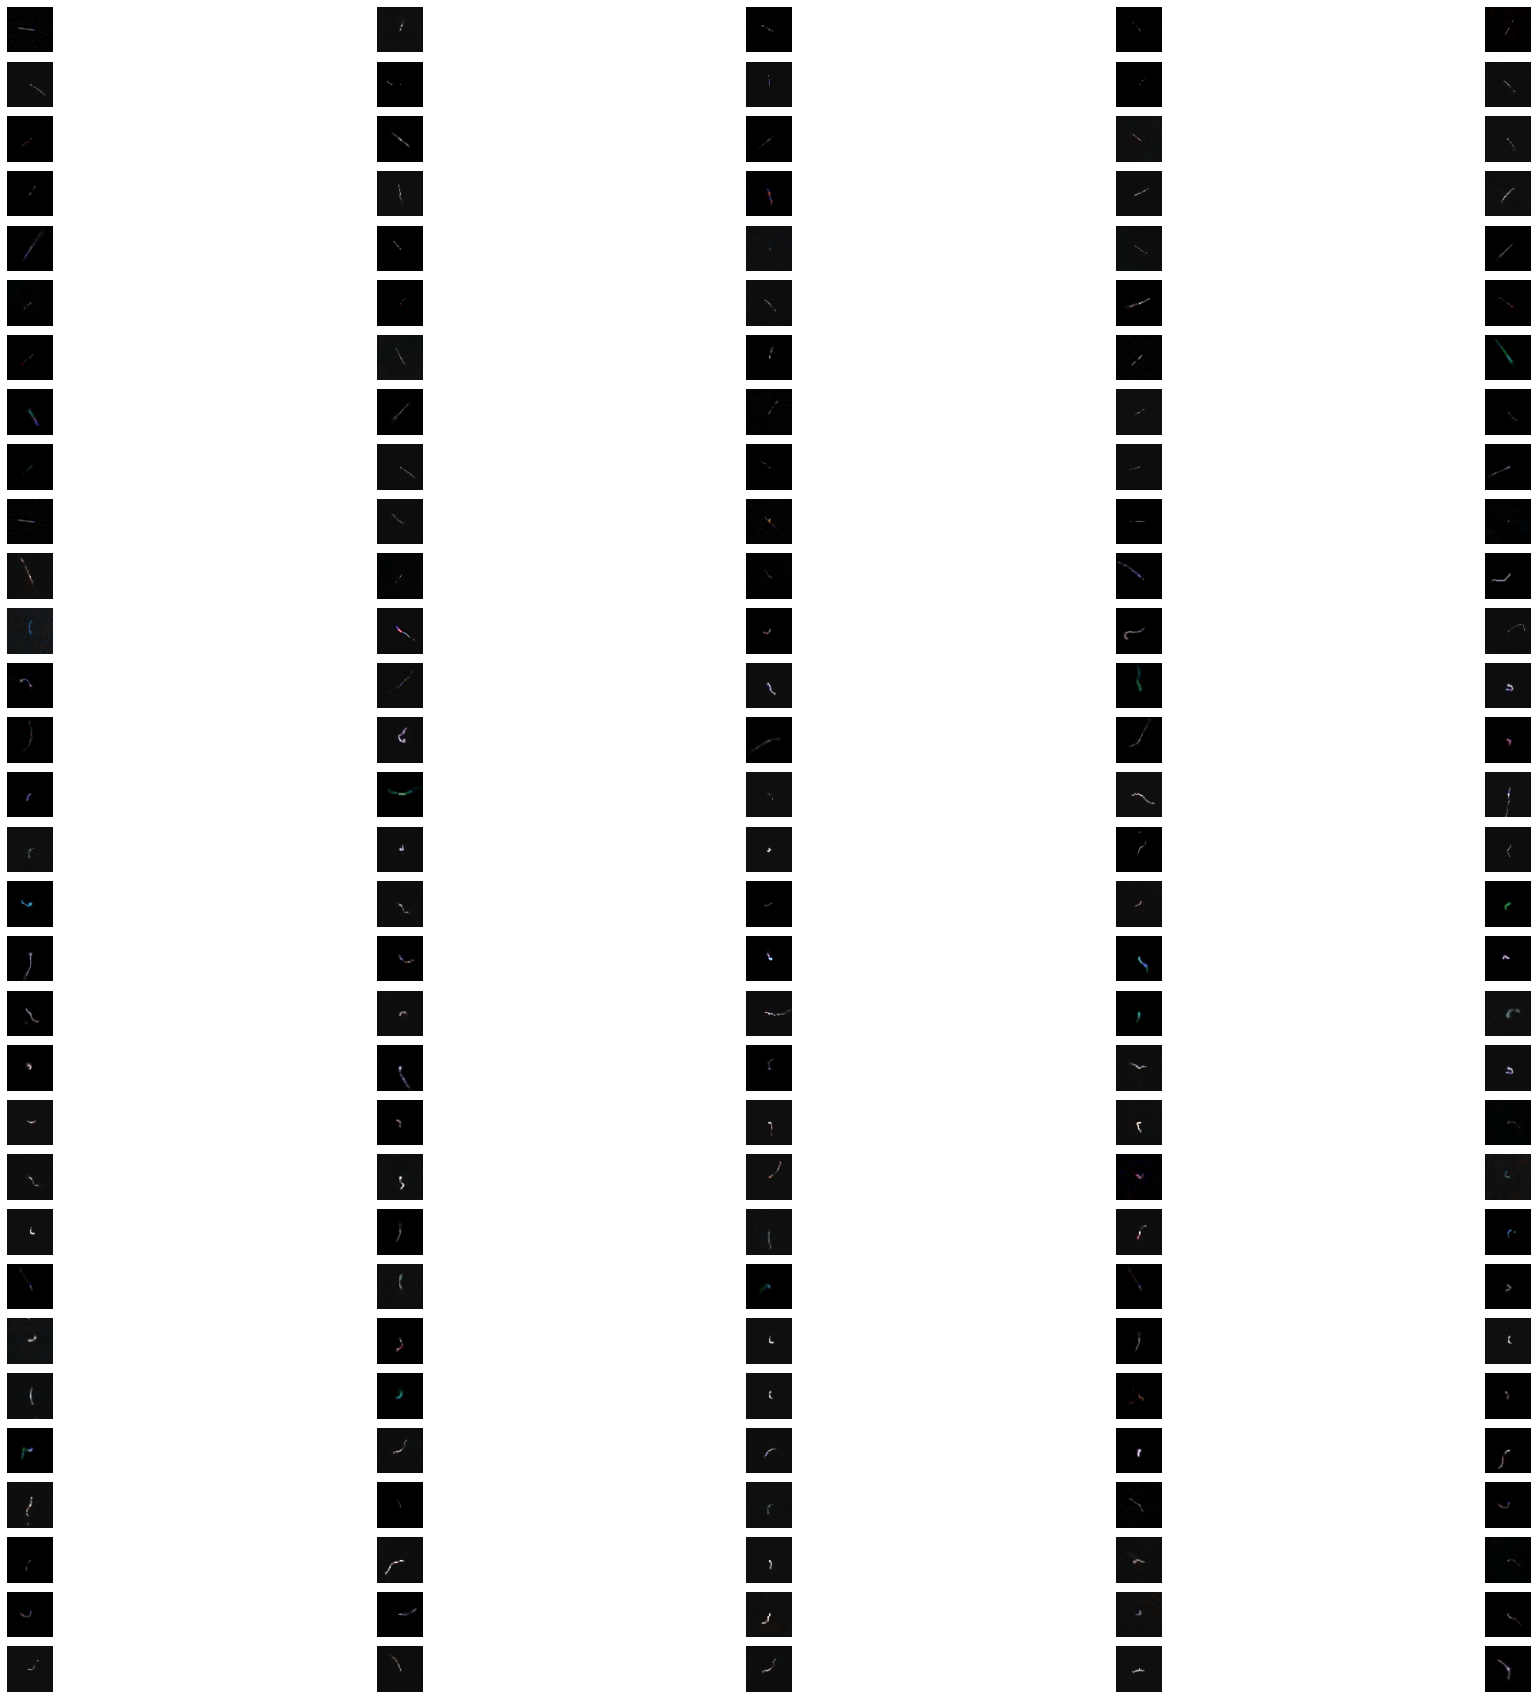

In [11]:
worms_embedding = encoder_embedding(TRACKS_AC, worms2_set[worms2_test])
worms_t_files = np.asarray(worms2_files)[worms2_test]

embedding = np.vstack([tracks_embedding, worms_embedding])
t_files = np.hstack([tracks_t_files, worms_t_files])

dbscan(embedding, t_files, 140)

[ 0  0  0 ...  0  0 -1]
[  17   95  217  259  302  431  718  760  768  942 1026 1080 1124 1198
 1229 1234 1514 1700 1827 1885 1919 1928 1976]
23
hit-images-final2/line\22009779.png
hit-images-final2/line\23300748.png
hit-images-final2/line\23768588.png
hit-images-final2/line\23447798.png
hit-images-final2/line\23769522.png
hit-images-final2/line\23072383.png
hit-images-final2/line\24520070.png
hit-images-final2/line\15079675.png
hit-images-final2/line\11853599.png
hit-images-final2/line\23769522.png
hit-images-final2/line\11834173.png
hit-images-final2/line\23930988.png
hit-images-final2/line\22267189.png
hit-images-final2/line\22174672.png
hit-images-final2/line\22391783.png
hit-images-final2/line\22490031.png
hit-images-final2/line\24579151.png
hit-images-final2/line\13855443.png
hit-images-final2/line\23316930.png
hit-images-final2/dot\11857243.png
hit-images-final2/line\11813671.png
hit-images-final2/line\23186082.png
hit-images-final2/me\6044.png


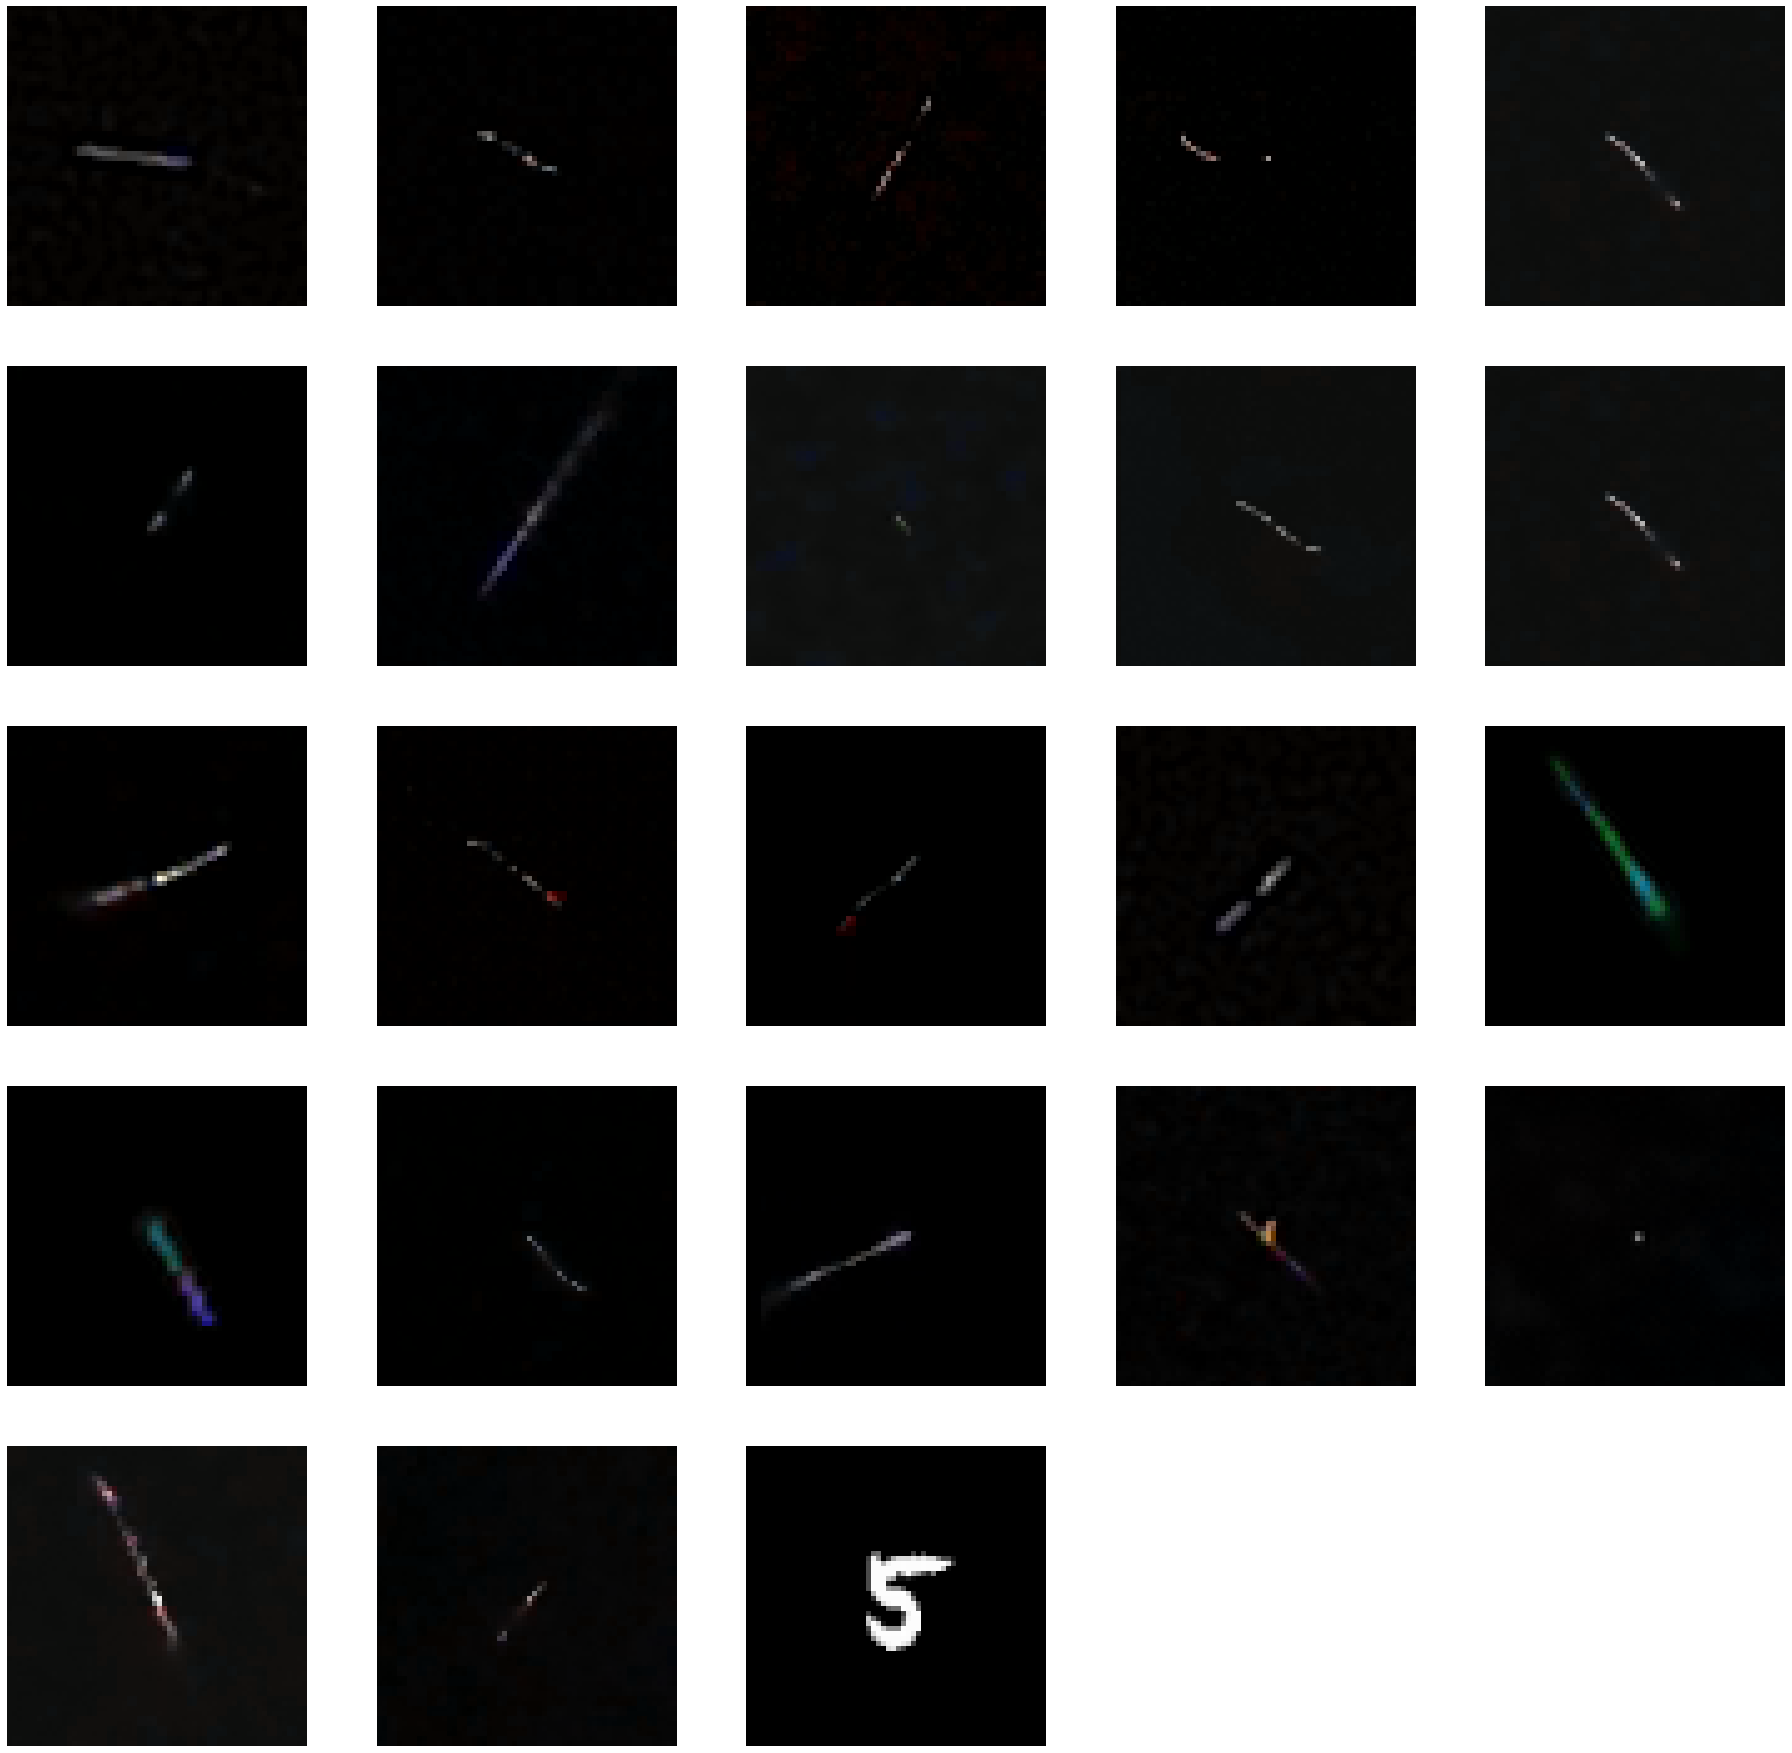

In [12]:
me_set, me_files = load_images('hit-images-final2/me')
me_embedding = encoder_embedding(TRACKS_AC, me_set)
me_files = np.asarray(me_files)

embedding = np.vstack([tracks_embedding, me_embedding])
t_files = np.hstack([tracks_t_files, me_files])

dbscan(embedding, t_files, 150)

In [13]:
def optics(embedding, t_files, eps):
    img_count = len(embedding)
    threshold = 1
    p = 16

    #for a in range(emb_array.shape[0]):
    #    emb_array[a] = emb_array[a] / w

    #emb_array_copy = np.copy(emb_array[0:img_count, 3:50])
    emb_array_copy = np.copy(embedding[0:img_count, 0:p])


    from sklearn.cluster import OPTICS
    from sklearn import metrics
    from sklearn.datasets import make_blobs
    from sklearn.preprocessing import StandardScaler

    db = OPTICS(min_samples=5, cluster_method='dbscan', eps=eps).fit(emb_array_copy)
    #core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    #core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    import matplotlib.pyplot as plt

    # Black removed and is used for noise instead.
    """
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = labels == k

        xy = emb_array_copy[class_member_mask & core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
        )

        xy = emb_array_copy[class_member_mask & ~core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )
    """
    result = np.where(labels == -1)
    my_ids = result[0]
    print(labels)
    print(my_ids)
    print(len(my_ids))


    import matplotlib.pyplot as plt


    fig = plt.figure(figsize=(32, 32))
    columns = 5
    rows = int(len(my_ids) / 5) + 1

    for aaa in range(len(my_ids)):
        #img_help = cv2.imread('d:\\dane\\credo\\png\\' + all_files_names[my_ids[aaa]])
        img_help = cv2.imread(t_files[my_ids[aaa]])
        print(t_files[my_ids[aaa]])

        aaa1 = aaa + 1
        xxxxx = (aaa % 5) + 1
        r = fig.add_subplot(rows, columns, aaa1)
        r.axis("off")
        plt.imshow(img_help)
        #cv2.imshow(str(aaa), img_help)
        #print(all_files_names[my_ids[0]])

    plt.show()

[0 0 0 ... 0 0 0]
[  17   95  217  259  302  431  718  760  768  942 1026 1080 1124 1198
 1229 1234 1514 1700 1827 1885 1919 1928]
22
hit-images-final2/line\22009779.png
hit-images-final2/line\23300748.png
hit-images-final2/line\23768588.png
hit-images-final2/line\23447798.png
hit-images-final2/line\23769522.png
hit-images-final2/line\23072383.png
hit-images-final2/line\24520070.png
hit-images-final2/line\15079675.png
hit-images-final2/line\11853599.png
hit-images-final2/line\23769522.png
hit-images-final2/line\11834173.png
hit-images-final2/line\23930988.png
hit-images-final2/line\22267189.png
hit-images-final2/line\22174672.png
hit-images-final2/line\22391783.png
hit-images-final2/line\22490031.png
hit-images-final2/line\24579151.png
hit-images-final2/line\13855443.png
hit-images-final2/line\23316930.png
hit-images-final2/dot\11857243.png
hit-images-final2/line\11813671.png
hit-images-final2/line\23186082.png


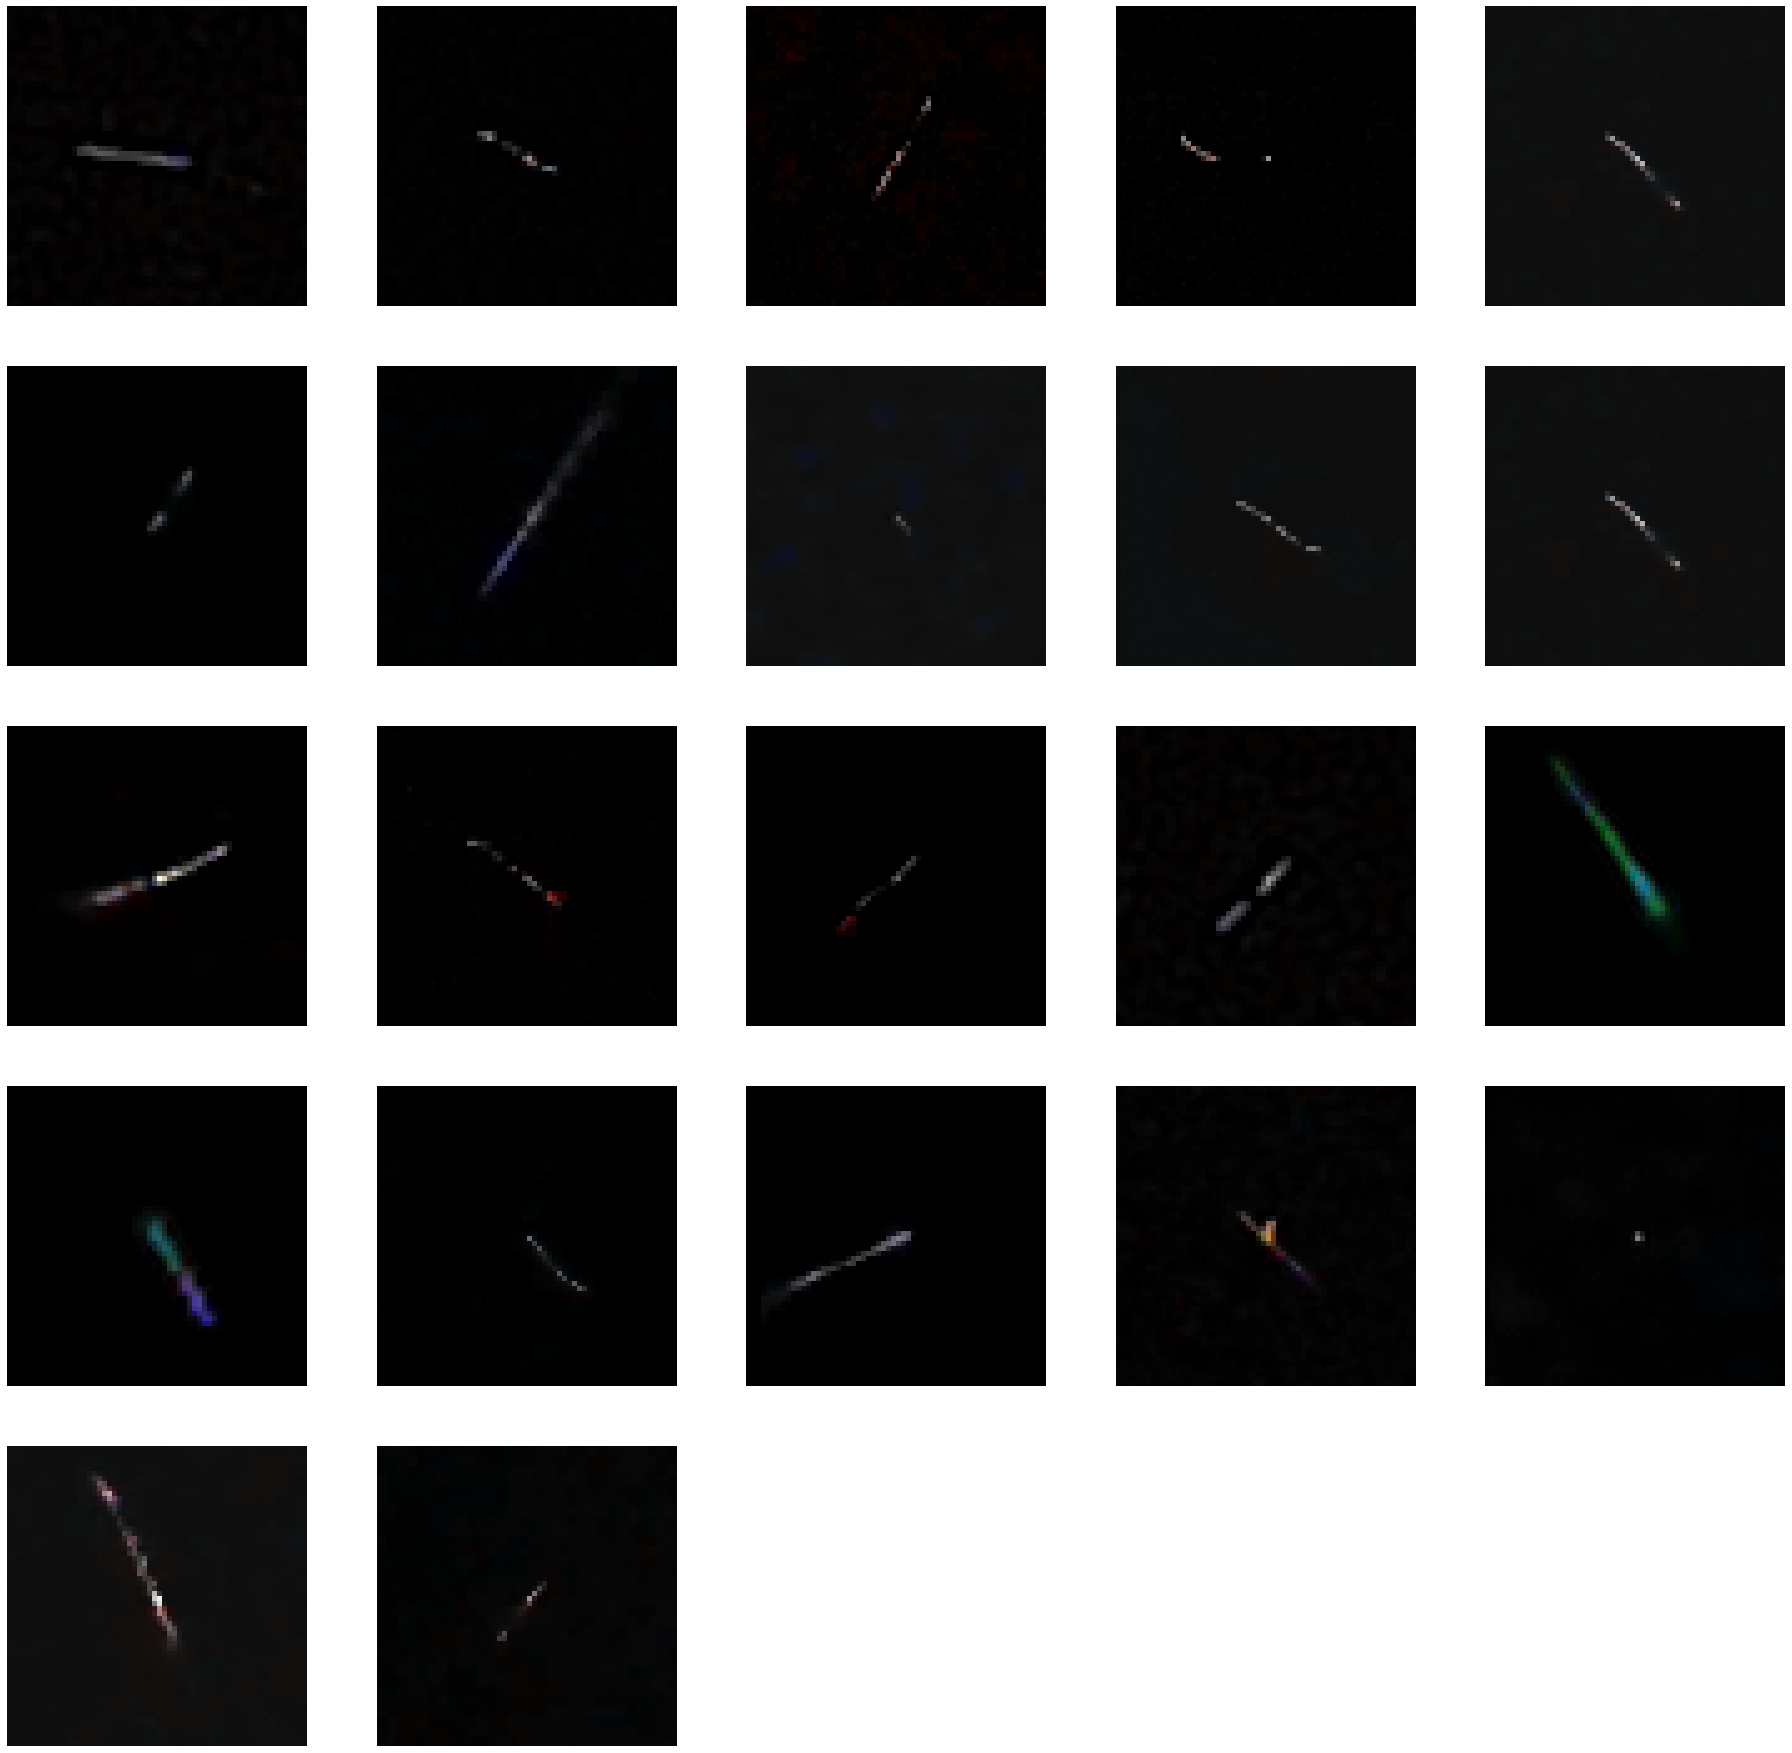

In [14]:
tracks_embedding = encoder_embedding(TRACKS_AC, tracks2_set[tracks2_test])
tracks_t_files = np.asarray(tacks2_files)[tracks2_test]
optics(tracks_embedding, tracks_t_files, 150)

[0 0 0 ... 0 0 0]
[  95  259  718  942 1026 1980 1988 1993 1999 2000 2003 2004 2005 2008
 2016 2020 2022 2023 2028 2031 2034 2036 2042 2043 2045 2047 2056 2057
 2059 2063 2064 2071 2072 2074 2075 2079 2080 2089 2090 2094 2102 2104
 2106 2109 2110 2117 2119 2127 2136 2138 2141 2147 2148 2155 2158 2163
 2170]
57
hit-images-final2/line\23300748.png
hit-images-final2/line\23447798.png
hit-images-final2/line\24520070.png
hit-images-final2/line\23769522.png
hit-images-final2/line\11834173.png
hit-images-final2/worms\22326858.png
hit-images-final2/worms\22347601.png
hit-images-final2/worms\22449196.png
hit-images-final2/worms\22351432.png
hit-images-final2/worms\22438037.png
hit-images-final2/worms\22203839.png
hit-images-final2/worms\22395093.png
hit-images-final2/worms\22305630.png
hit-images-final2/worms\22398103.png
hit-images-final2/worms\22325457.png
hit-images-final2/worms\22437067.png
hit-images-final2/worms\22011869.png
hit-images-final2/worms\22232598.png
hit-images-final2/worms\225

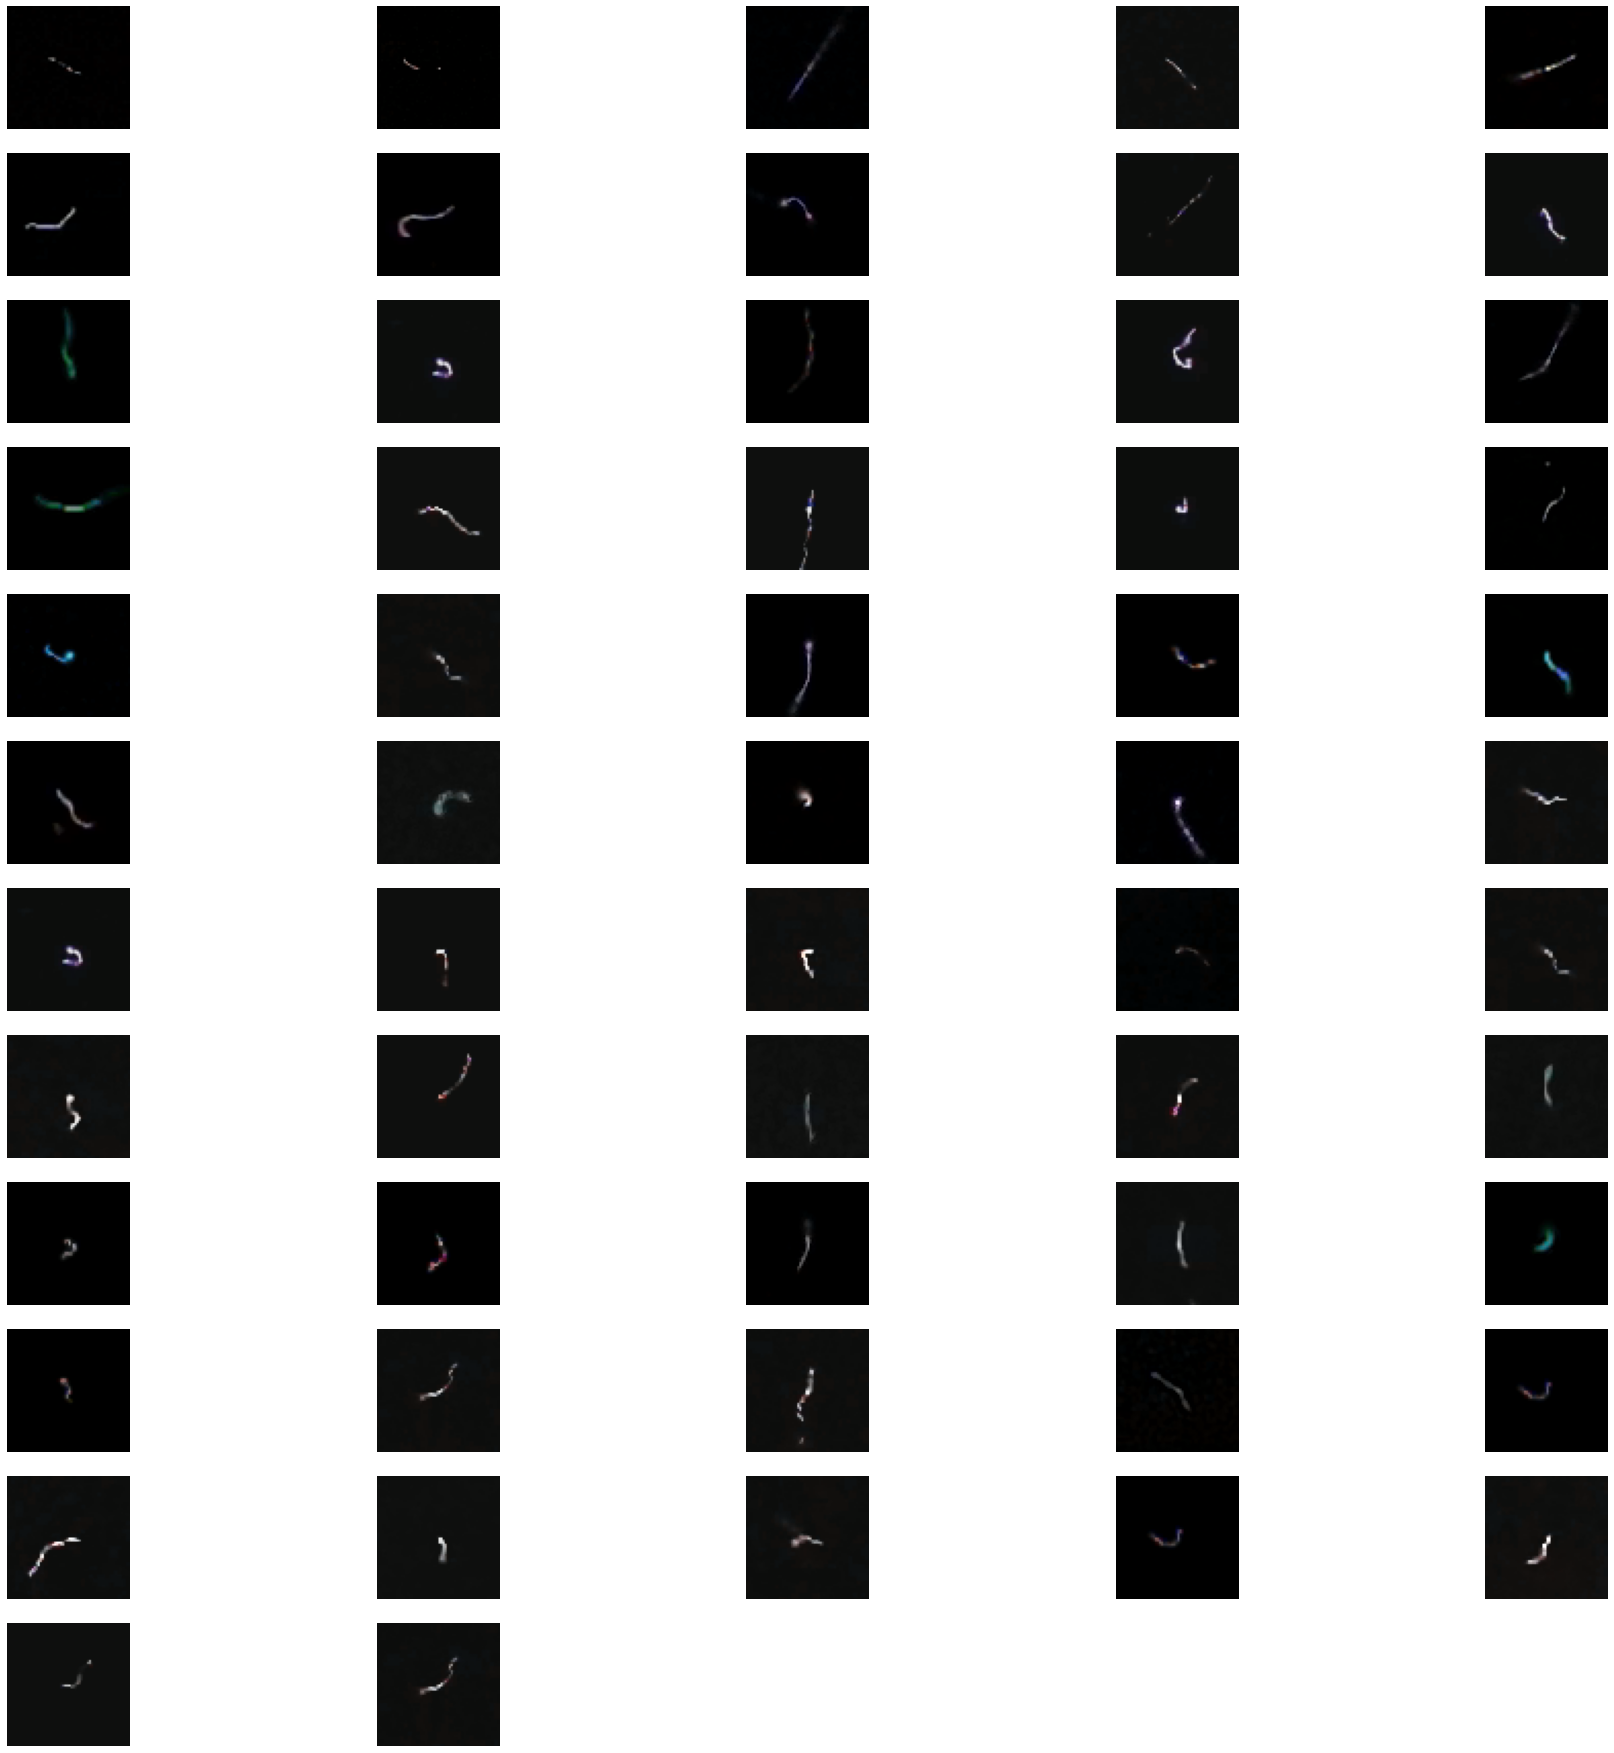

In [15]:
worms_embedding = encoder_embedding(TRACKS_AC, worms2_set[worms2_test])
worms_t_files = np.asarray(worms2_files)[worms2_test]

embedding = np.vstack([tracks_embedding, worms_embedding])
t_files = np.hstack([tracks_t_files, worms_t_files])

optics(embedding, t_files, 175)

[ 0  0  0 ...  0  0 -1]
[  17   95  217  259  302  431  718  760  768  942 1026 1080 1124 1198
 1229 1234 1514 1700 1827 1885 1919 1928 1976]
23
hit-images-final2/line\22009779.png
hit-images-final2/line\23300748.png
hit-images-final2/line\23768588.png
hit-images-final2/line\23447798.png
hit-images-final2/line\23769522.png
hit-images-final2/line\23072383.png
hit-images-final2/line\24520070.png
hit-images-final2/line\15079675.png
hit-images-final2/line\11853599.png
hit-images-final2/line\23769522.png
hit-images-final2/line\11834173.png
hit-images-final2/line\23930988.png
hit-images-final2/line\22267189.png
hit-images-final2/line\22174672.png
hit-images-final2/line\22391783.png
hit-images-final2/line\22490031.png
hit-images-final2/line\24579151.png
hit-images-final2/line\13855443.png
hit-images-final2/line\23316930.png
hit-images-final2/dot\11857243.png
hit-images-final2/line\11813671.png
hit-images-final2/line\23186082.png
hit-images-final2/me\6044.png


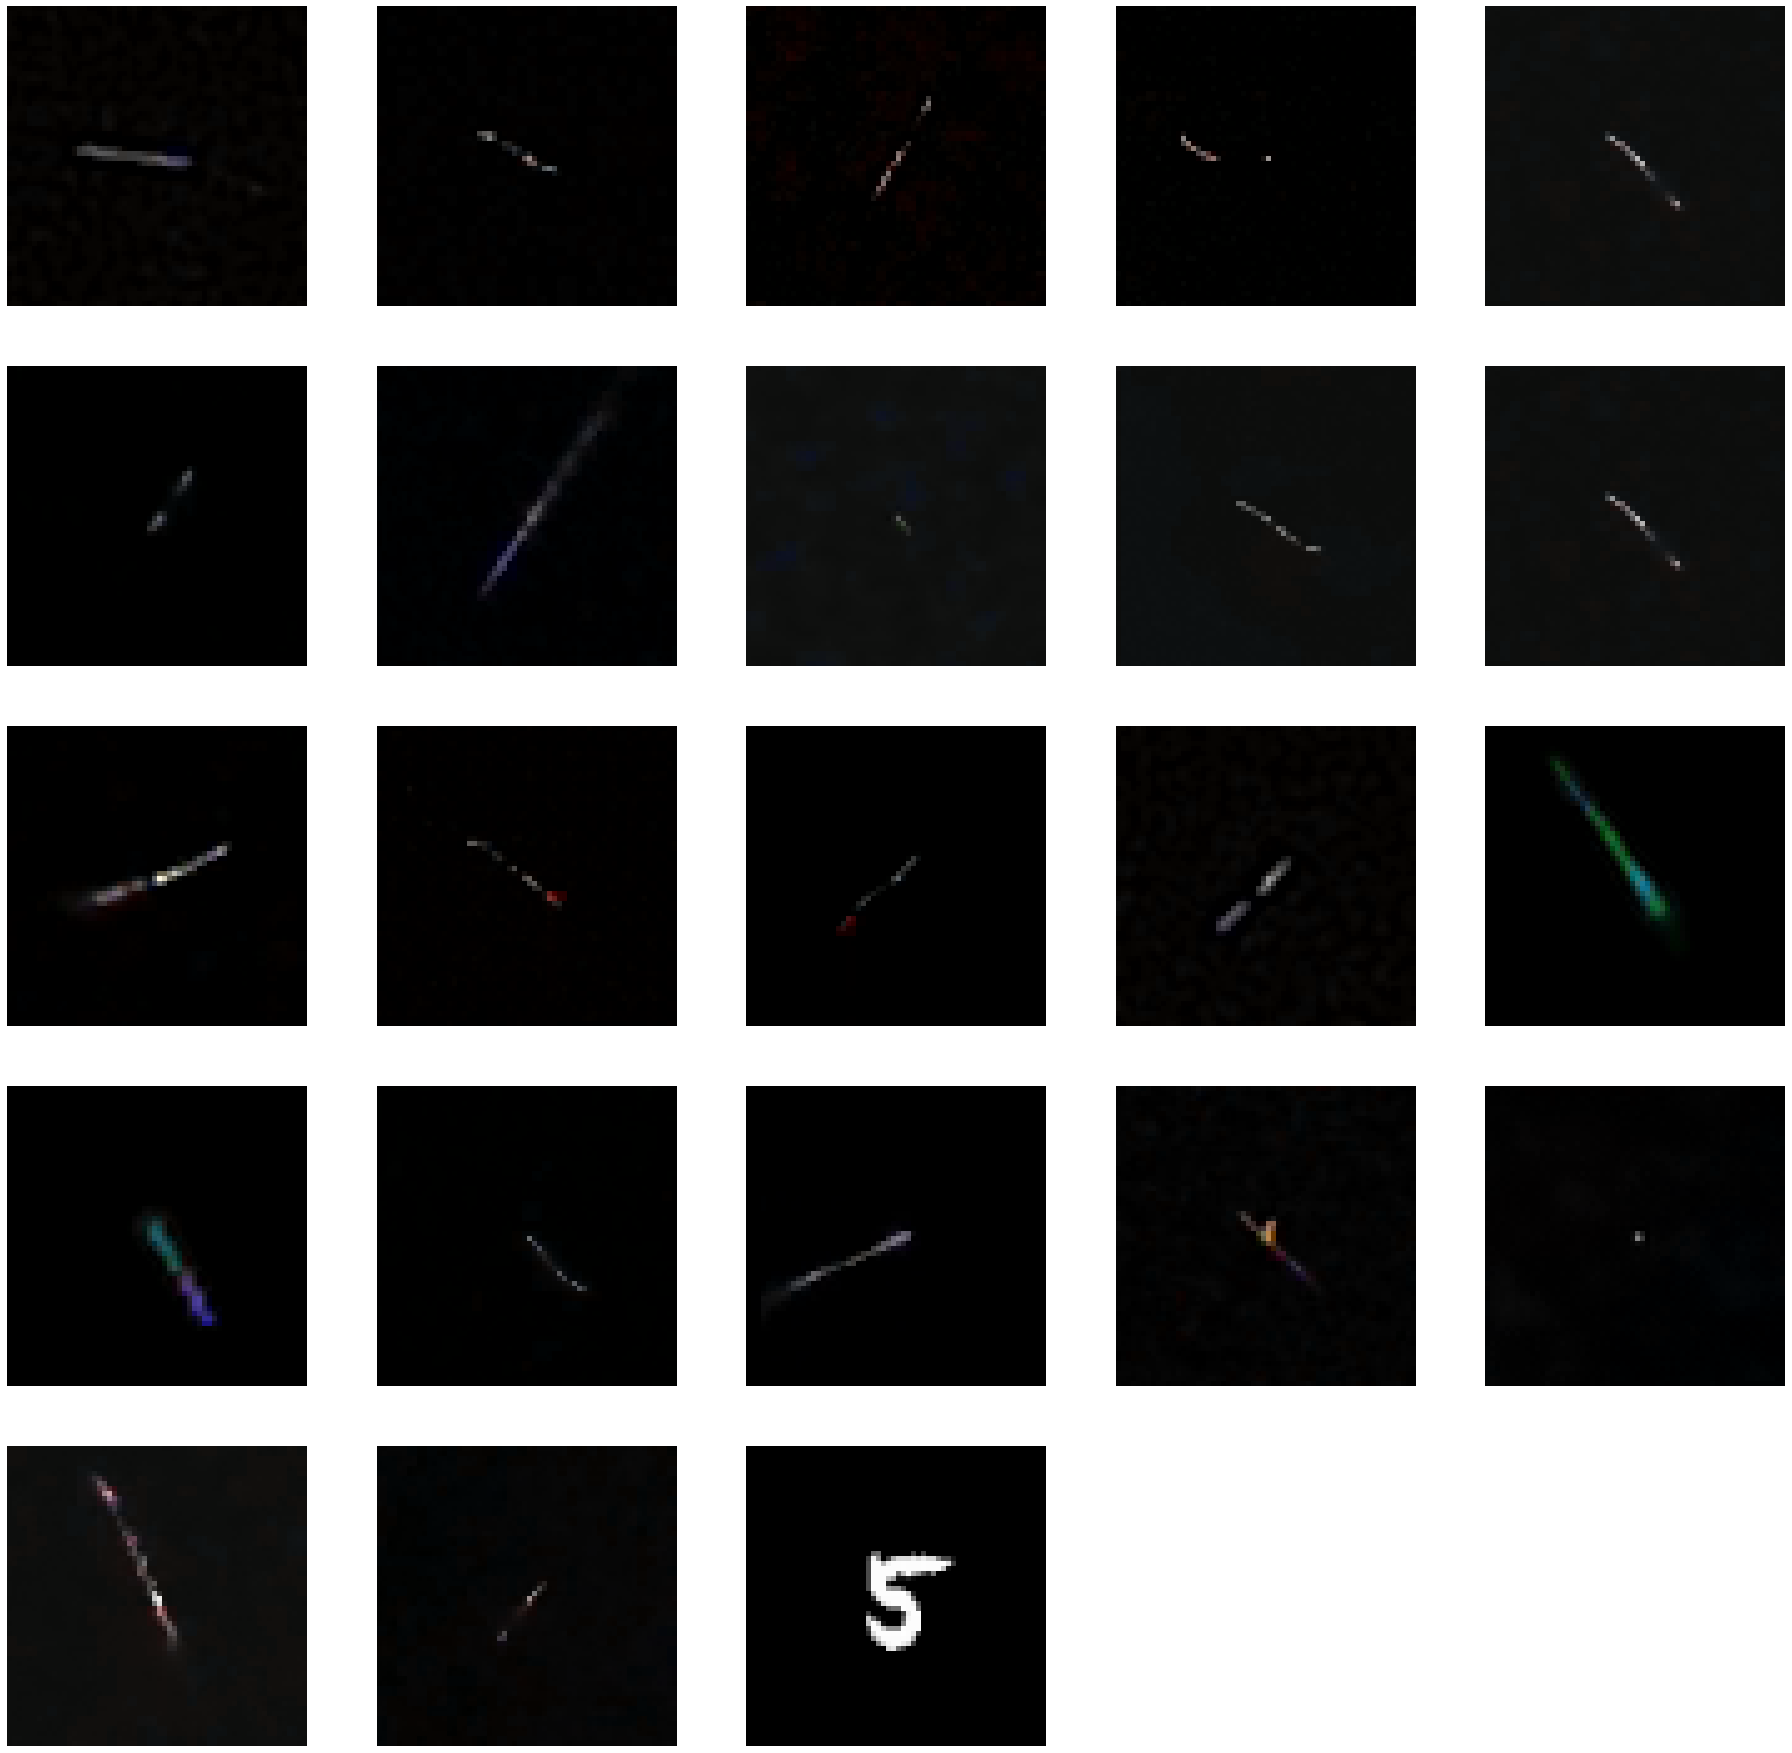

In [16]:
me_set, me_files = load_images('hit-images-final2/me')
me_embedding = encoder_embedding(TRACKS_AC, me_set)
me_files = np.asarray(me_files)

embedding = np.vstack([tracks_embedding, me_embedding])
t_files = np.hstack([tracks_t_files, me_files])

optics(embedding, t_files, 150)

[ 0  0  0 ...  0  0 -1]
[1976]
1
hit-images-final2/me\6044.png


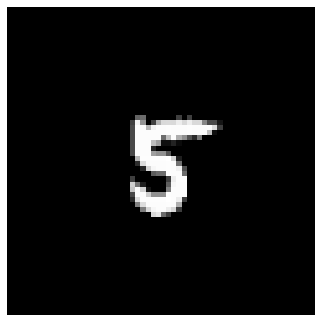

In [17]:
me_set, me_files = load_images('hit-images-final2/me')
me_embedding = encoder_embedding(TRACKS_AC, me_set)
me_files = np.asarray(me_files)

embedding = np.vstack([tracks_embedding, me_embedding])
t_files = np.hstack([tracks_t_files, me_files])

optics(embedding, t_files, 220)

In [18]:
def algomerative(embedding, t_files, eps):
    img_count = len(embedding)
    threshold = 1
    p = 16

    #for a in range(emb_array.shape[0]):
    #    emb_array[a] = emb_array[a] / w

    #emb_array_copy = np.copy(emb_array[0:img_count, 3:50])
    emb_array_copy = np.copy(embedding[0:img_count, 0:p])

    from sklearn.cluster import AgglomerativeClustering
    clustering = AgglomerativeClustering(distance_threshold = eps, n_clusters=None).fit(emb_array_copy)

    """
    count_labels = len(set(clustering.labels_))

    print(count_labels)
    xxx = np.zeros(count_labels)
    for a in range(xxx.shape[0]):
        xxx[a] =
    print(clustering.labels_)
    """


    from collections import Counter
    c=Counter(clustering.labels_)
    values_list = list(c.values())
    keys_list = list(c.keys())
    #print(c.values())
    #print(c.keys())

    def find_all_elements(my_list, id):
        ret_list = []
        for ind in range(len(my_list)):
            if my_list[ind] == id:
                ret_list.append(ind)
        return ret_list

    #xxxx = [1,1,2,3,4,5,1]
    #print(find_all_elements(xxxx, 1))

    all_cluster_ids = []
    all_ids = find_all_elements(values_list, 1)
    for a in all_ids:
        all_cluster_ids.append(keys_list[a])
    print(all_ids)
    print(all_cluster_ids)

    my_ids = []
    for a in range(len(clustering.labels_)):
        if clustering.labels_[a] in all_cluster_ids:
            my_ids.append(a)
    print(my_ids)


    import matplotlib.pyplot as plt


    fig = plt.figure(figsize=(8, 8))
    columns = 5
    rows = int(len(my_ids) / 5) + 1

    columns2 = 11
    rows2 = int(len(my_ids) / columns2) + 1
    ret_img = np.zeros((128 * rows2, 128 * columns2, 3))

    xx = 0
    yy = 0
    for aaa in range(len(my_ids)):
        #img_help = cv2.imread('d:\\dane\\credo\\png\\' + all_files_names[my_ids[aaa]])
        img_help = cv2.imread(t_files[my_ids[aaa]])
        print(t_files[my_ids[aaa]])
        aaa1 = aaa + 1

        ret_img[128 * yy : 128 * (yy + 1), 128 * xx : 128 * (xx + 1), :] = cv2.resize(img_help, (128, 128))
        xx = xx + 1

        if xx > columns2 - 1:
            xx = 0
            yy = yy + 1

        xxxxx = (aaa % 5) + 1



        fig.add_subplot(rows, columns, aaa1)
        plt.imshow(img_help)



        #cv2.imshow(str(aaa), img_help)
        #print(all_files_names[my_ids[0]])
    ret_img = ret_img.astype(np.uint8)
    cv2.imshow("ret_img",ret_img)
    plt.show()

me_set, me_files = load_images('hit-images-final2/me')
me_embedding = encoder_embedding(TRACKS_AC, me_set)
me_files = np.asarray(me_files)

embedding = np.vstack([tracks_embedding, me_embedding])
t_files = np.hstack([tracks_t_files, me_files])

algomerative(embedding, t_files, 250)

[15, 36, 55, 79, 134, 155, 157, 167, 168, 169, 203, 251, 255, 256, 262, 264, 268, 277, 280, 283, 285, 288, 289, 290, 291, 292]
[221, 206, 243, 275, 188, 229, 265, 191, 268, 262, 239, 159, 223, 150, 256, 192, 166, 242, 196, 219, 267, 237, 280, 214, 198, 227]
[17, 40, 60, 95, 217, 259, 264, 302, 308, 309, 431, 718, 760, 768, 857, 942, 1026, 1182, 1234, 1442, 1469, 1601, 1700, 1827, 1885, 1928]
hit-images-final2/line\22009779.png
hit-images-final2/line\15833603.png
hit-images-final2/line\21978364.png
hit-images-final2/line\23300748.png
hit-images-final2/line\23768588.png
hit-images-final2/line\23447798.png
hit-images-final2/line\23758907.png
hit-images-final2/line\23769522.png
hit-images-final2/line\23764899.png
hit-images-final2/line\13693307.png
hit-images-final2/line\23072383.png
hit-images-final2/line\24520070.png
hit-images-final2/line\15079675.png
hit-images-final2/line\11853599.png
hit-images-final2/line\23423151.png
hit-images-final2/line\23769522.png
hit-images-final2/line\118341

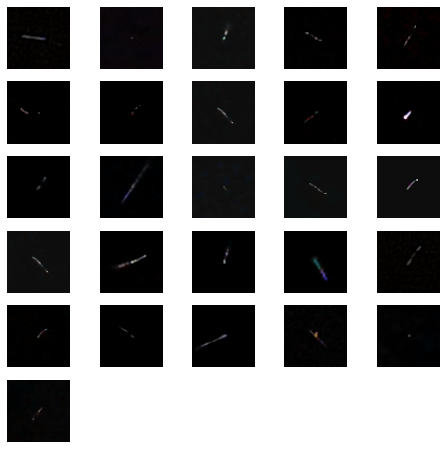

In [21]:
me_set, me_files = load_images('hit-images-final2/me')
me_embedding = encoder_embedding(TRACKS_AC, me_set)
me_files = np.asarray(me_files)

embedding = np.vstack([tracks_embedding, me_embedding])
t_files = np.hstack([tracks_t_files, me_files])

algomerative(embedding, t_files, 250)

[130, 140, 187, 193, 208, 212, 221, 223, 225, 236, 241, 242, 244, 245, 246, 248, 250, 251, 253, 257, 258, 259]
[215, 255, 201, 233, 213, 231, 253, 217, 257, 245, 226, 132, 193, 239, 159, 139, 254, 229, 166, 206, 148, 244]
[259, 302, 718, 1026, 1980, 1988, 2003, 2005, 2016, 2036, 2057, 2064, 2072, 2074, 2079, 2090, 2094, 2110, 2119, 2155, 2163, 2170]
hit-images-final2/line\23447798.png
hit-images-final2/line\23769522.png
hit-images-final2/line\24520070.png
hit-images-final2/line\11834173.png
hit-images-final2/worms\22326858.png
hit-images-final2/worms\22347601.png
hit-images-final2/worms\22203839.png
hit-images-final2/worms\22305630.png
hit-images-final2/worms\22325457.png
hit-images-final2/worms\22436402.png
hit-images-final2/worms\11802118.png
hit-images-final2/worms\22395093.png
hit-images-final2/worms\22343771.png
hit-images-final2/worms\11699067.png
hit-images-final2/worms\22269230.png
hit-images-final2/worms\22054834.png
hit-images-final2/worms\22429256.png
hit-images-final2/worms

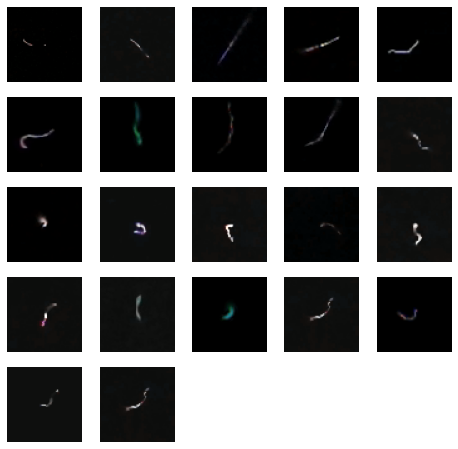